# 6.6  Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning the time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarising the wildfire data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# This option ensures the graphs created are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# Define path

path = r'/Users/faridchehraz/Desktop/Python/Master - USA Wildfires'

In [4]:
#Import US_wildfires pkl file

df = pd.read_pickle(os.path.join(path, '2. Data', 'b. Prepared Data', 'US_wildfires.pkl'))

In [5]:
df.head()

,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,NWCG_GENERAL_CAUSE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_NAME,DISC_MONTH,DISC_DOW
0,1,2005,2005-02-02,33,Power generation/transmission/distribution,0.10,A,40.036944,-121.005833,USFS,CA,63,Plumas County,2,Wednesday
1,2,2004,2004-05-12,133,Natural,0.25,A,38.933056,-120.404444,USFS,CA,61,Placer County,5,Wednesday
2,3,2004,2004-05-31,152,Debris and open burning,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17,El Dorado County,5,Monday
3,4,2004,2004-06-28,180,Natural,0.10,A,38.559167,-119.913333,USFS,CA,3,Alpine County,6,Monday
4,5,2004,2004-06-28,180,Natural,0.10,A,38.559167,-119.933056,USFS,CA,3,Alpine County,6,Monday


In [6]:
# Extract Year & Month from DISCOVERY_DATE column

df['Year/Month'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.strftime('%Y-%m')

In [7]:
# Change Year/Month column data type to datetime64

df['Year/Month'] = pd.to_datetime(df['Year/Month'])

In [8]:
df.dtypes

FOD_ID                         int64
FIRE_YEAR                      int64
DISCOVERY_DATE        datetime64[ns]
DISCOVERY_DOY                  int64
NWCG_GENERAL_CAUSE            object
FIRE_SIZE                    float64
FIRE_SIZE_CLASS               object
LATITUDE                     float64
LONGITUDE                    float64
OWNER_DESCR                   object
STATE                         object
COUNTY                        object
FIPS_NAME                     object
DISC_MONTH                     int64
DISC_DOW                      object
Year/Month            datetime64[ns]
dtype: object

In [9]:
df_monthly = df.groupby(['Year/Month'])[['FIRE_SIZE']].sum()

In [10]:
type(df_monthly)

pandas.core.frame.DataFrame

[Text(0, -1000000.0, '-1,000,000'),
 Text(0, 0.0, '0'),
 Text(0, 1000000.0, '1,000,000'),
 Text(0, 2000000.0, '2,000,000'),
 Text(0, 3000000.0, '3,000,000'),
 Text(0, 4000000.0, '4,000,000'),
 Text(0, 5000000.0, '5,000,000'),
 Text(0, 6000000.0, '6,000,000')]

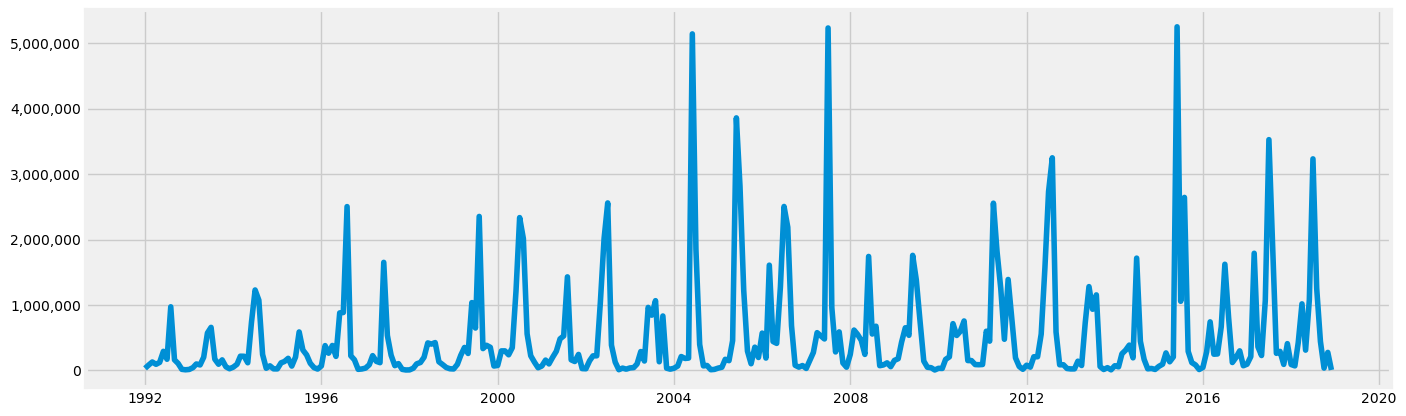

In [11]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_monthly)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

### 2. Subsetting, wrangling, and cleaning time-series data

In [12]:
#Categorise wildfire causes & add to dataframe

def Cause_category(row):

  if row['NWCG_GENERAL_CAUSE'] in ('Natural'):
    return 'Natural'
  elif row['NWCG_GENERAL_CAUSE'] in ('Debris and open burning','Firearms and explosives use',
                                     'Misuse of fire by a minor'):
    return 'Accidental'
  elif row['NWCG_GENERAL_CAUSE'] in ('Equipment and vehicle use','Power generation/transmission/distribution',
                                   'Railroad operations and maintenance'):
    return 'Accidental Industry'
  elif row['NWCG_GENERAL_CAUSE'] in ('Arson/incendiarism'):
    return 'Malicious'
  elif row['NWCG_GENERAL_CAUSE'] in ('Fireworks','Recreation and ceremony','Smoking'):
    return 'Recreation'
  elif row['NWCG_GENERAL_CAUSE'] in ('Other causes','Missing data/not specified/undetermined'):
    return 'Other/Unknown'

  else: return np.nan

df['Cause_cat'] = df.apply(Cause_category, axis=1)

In [13]:
df['Cause_cat'].value_counts(dropna=False)

Accidental             574054
Other/Unknown          557201
Natural                312807
Malicious              310320
Accidental Industry    240752
Recreation             171619
Name: Cause_cat, dtype: int64

#### Creating subset of 'Natural' cause wildfires to ascertain if there has been an increase in acres of land directly affected by wildfires over the last 27 years

In [14]:
#Create subset for the Natural cause wildfires

df_nat = df[df['Cause_cat']=='Natural']

In [15]:
df_nat['Cause_cat'].value_counts(dropna=False)

Natural    312807
Name: Cause_cat, dtype: int64

In [16]:
df_nat_monthly = df_nat.groupby(['Year/Month'])[['FIRE_SIZE']].sum()

In [17]:
df_nat_monthly.shape

(324, 1)

In [18]:
df_nat_monthly.head()

,FIRE_SIZE
Year/Month,
1992-01-01,438.99
1992-02-01,69.46
1992-03-01,1048.10
1992-04-01,1386.88
1992-05-01,11572.40


[Text(0, -1000000.0, '-1,000,000'),
 Text(0, 0.0, '0'),
 Text(0, 1000000.0, '1,000,000'),
 Text(0, 2000000.0, '2,000,000'),
 Text(0, 3000000.0, '3,000,000'),
 Text(0, 4000000.0, '4,000,000'),
 Text(0, 5000000.0, '5,000,000'),
 Text(0, 6000000.0, '6,000,000')]

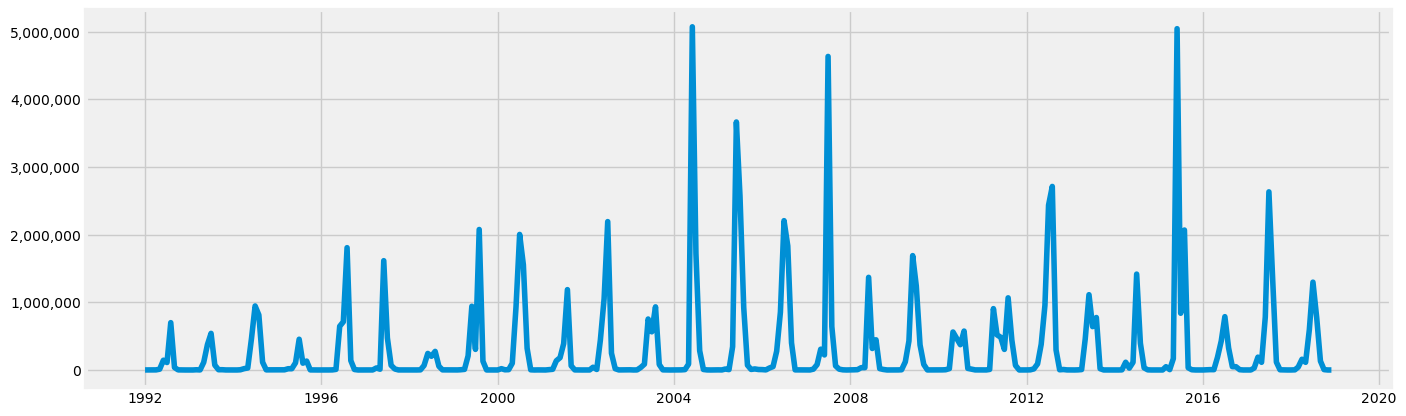

In [19]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_nat_monthly)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

In [20]:
# Check for missing values (you shouldn't have any)

df_nat_monthly.isnull().sum() 

FIRE_SIZE    0
dtype: int64

In [21]:
# Check for duplicates

dups = df_nat_monthly.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [23]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_nat_monthly, model='additive')

In [24]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

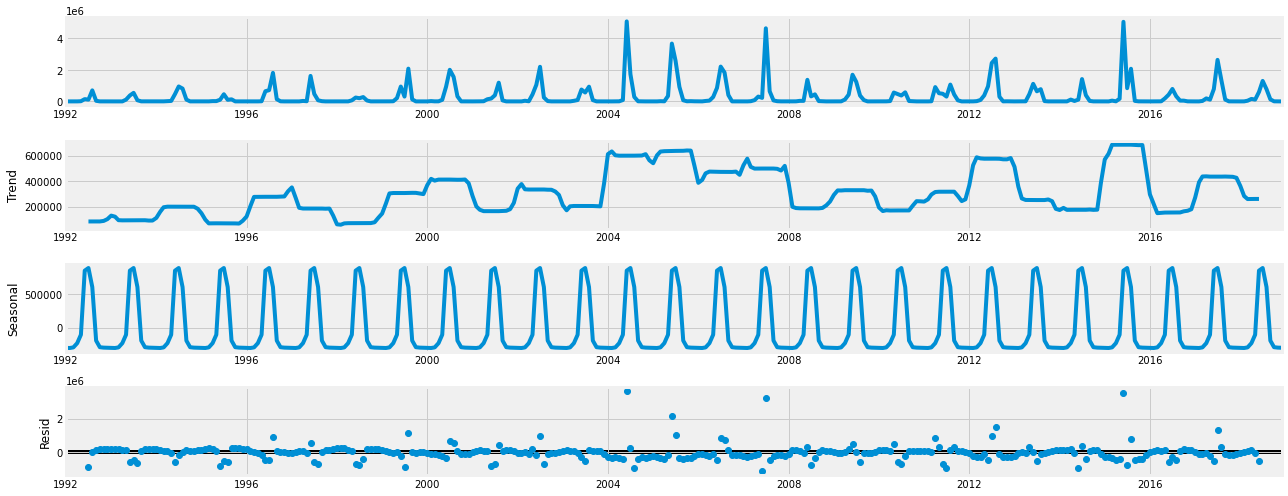

In [25]:
# Plot the separate components

decomposition.plot()
plt.show()

The above decomposition shows for natural cause wildfires over the period of 27 years:

    - An upward trend in the area of land directly affected
    
    - Clear seasonality; more natural cause wildfires would be expected in the warmer months
    
    - An increase in the frequency of a exceptionally large areas of land burned (outlying data points)
    
    - All of the above observations tie in with what would be expected due climate change

### 4. Testing for stationarity

In [26]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_nat_monthly['FIRE_SIZE'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.635034
p-value                          0.005126
Number of Lags Used             12.000000
Number of Observations Used    311.000000
Critical Value (1%)             -3.451553
Critical Value (5%)             -2.870879
Critical Value (10%)            -2.571746
dtype: float64


The p-value is < 0.05 which makes it 'significant'.

As the Test Statistic of -3.635034 < the critical value of the corresponding significance level of 5%, we can reject the null hypothesis.


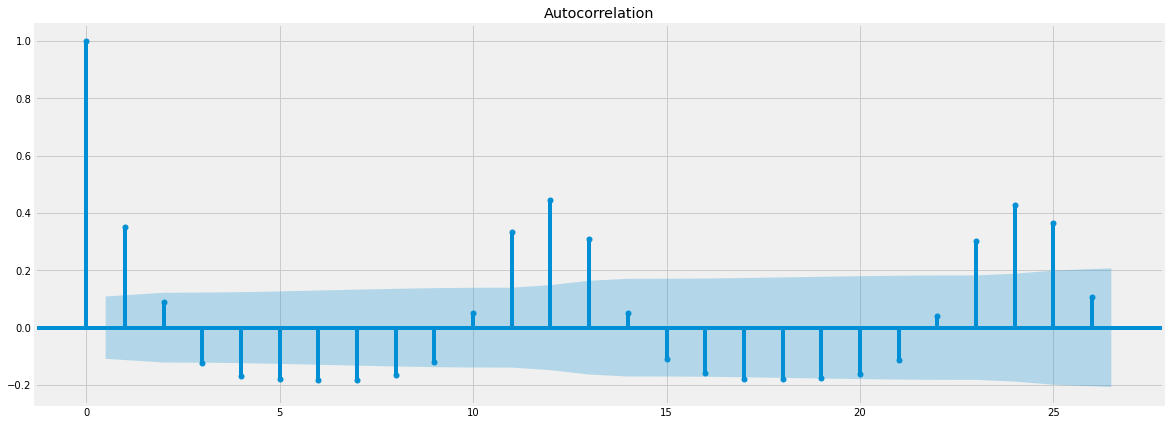

In [27]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_nat_monthly)
plt.show()

### 5. Stationarising the Wildfire Data

In [28]:
data_diff = df_nat_monthly - df_nat_monthly.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [29]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [30]:
data_diff.head()

,FIRE_SIZE
Year/Month,
1992-02-01,-369.53
1992-03-01,978.64
1992-04-01,338.78
1992-05-01,10185.52
1992-06-01,133133.85


In [31]:
data_diff.columns

Index(['FIRE_SIZE'], dtype='object')

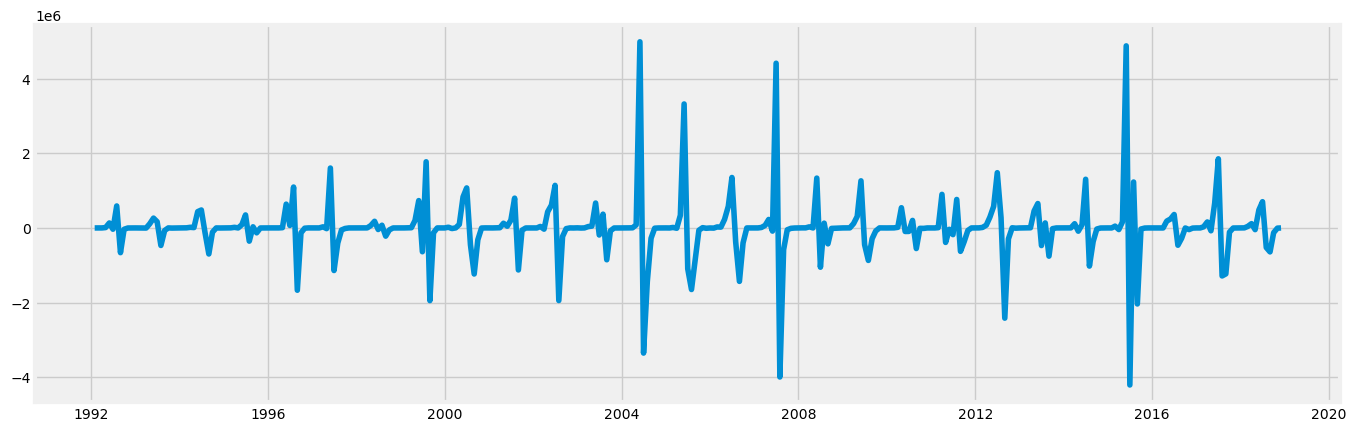

In [32]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [33]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.308932e+01
p-value                        1.802183e-24
Number of Lags Used            1.100000e+01
Number of Observations Used    3.110000e+02
Critical Value (1%)           -3.451553e+00
Critical Value (5%)           -2.870879e+00
Critical Value (10%)          -2.571746e+00
dtype: float64


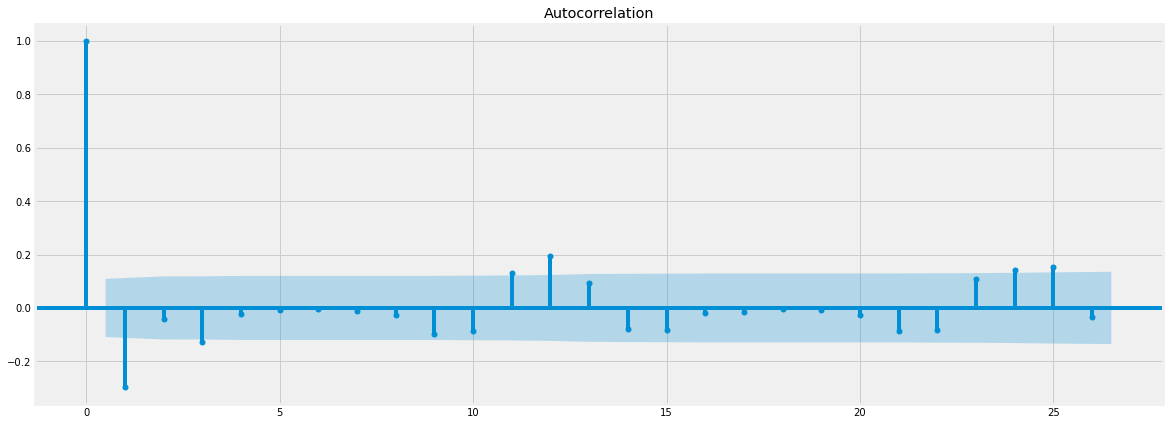

In [34]:
plot_acf(data_diff)
plt.show()